### Ryan Passenger Review

Reasech Questions:
* What are the most common words and sentiments expressed in the reviews?
* How do passenger ratings distribute across different aspects of the travel experience?
* Are there any discernible trends or patterns over time in passenger feedback?
* Can we identify specific areas for improvement based on passenger sentiments?
* What are the prevalent themes/topics discussed in the reviews, and how do they correlate with sentiments?
* Summarize Customer Feedback (Optional)

### EDA
 - Explore the distribution of review ratings.
 - Visualize the distribution of sentiments (positive, negative, neutral) in the dataset using bar plots or pie charts. 
 - Investigate the distribution of review lengths (number of words or characters) for each sentiment category. This can help identify if sentiment varies        based on the length of the review
 - Analyze how sentiment varies over time. Plotting sentiment trends over time can reveal seasonal patterns or changes in sentiment trends.
 - Explore the most frequent words or phrases used in the reviews (word clouds, frequency plots, etc.).
 - Analyze the route showing most negative feedbacks.
 - Explore word associations or co-occurrences within each sentiment category. Identify words that frequently appear together with positive or negative sentiments, which can provide insights into the language used by customers.

In [92]:
import pandas as pd
from collections import Counter
import string
import numpy as np

# Core packages
import string
import re

# NLP Packages
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk import bigrams, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import re

import matplotlib.pyplot as plt

## Sentiment Analysis   
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import networkx as nx

In [93]:
# Get Data
ryan_pas_review_df = pd.read_csv('./data/ryanair_reviews.csv')
ryan_pas_review_df.head()

,Unnamed: 0,Date Published,Overall Rating,Passenger Country,Trip_verified,Comment title,Comment,Aircraft,Type Of Traveller,Seat Type,...,Destination,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity
0,0,2024-02-03,10.0,United Kingdom,Not Verified,"""bang on time and smooth flights""",Flew back from Faro to London Luton Friday 2nd...,Boeing 737 900,Family Leisure,Economy Class,...,Luton,February 2024,4.0,5.0,3.0,4.0,4.0,yes,NaN,NaN
1,1,2024-01-26,10.0,United Kingdom,Trip Verified,"""Another good affordable flight""",Another good affordable flight with Ryanair. O...,NaN,Couple Leisure,Economy Class,...,Alicante,January 2024,3.0,5.0,3.0,5.0,5.0,yes,NaN,NaN
2,2,2024-01-20,10.0,United Kingdom,Trip Verified,“Really impressed!”,"Really impressed! You get what you pay for, th...",Boeing 737-800,Couple Leisure,Economy Class,...,Paris Beauvais,October 2023,5.0,5.0,4.0,5.0,5.0,yes,NaN,NaN
3,3,2024-01-07,6.0,United Kingdom,Trip Verified,“a decent offering from Ryanair”,I should like to review my flight from Faro to...,Boeing 737,Solo Leisure,Economy Class,...,Liverpool,January 2024,3.0,2.0,1.0,3.0,3.0,yes,NaN,NaN
4,4,2024-01-06,10.0,Israel,Trip Verified,“cabin crew were welcoming and friendly”,"Flight left the gate ahead of schedule, fare w...",Boeing 737-800,Solo Leisure,Economy Class,...,Manchester,January 2024,4.0,5.0,NaN,4.0,5.0,yes,NaN,NaN


In [94]:
ryan_pas_review_df.shape

(2249, 21)

In [95]:
ryan_pas_review_df.columns

Index(['Unnamed: 0', 'Date Published', 'Overall Rating', 'Passenger Country',
       'Trip_verified', 'Comment title', 'Comment', 'Aircraft',
       'Type Of Traveller', 'Seat Type', 'Origin', 'Destination', 'Date Flown',
       'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Ground Service', 'Value For Money', 'Recommended',
       'Inflight Entertainment', 'Wifi & Connectivity'],
      dtype='object')

## Explore the distribution of review ratings on various aspects of airline.

In [96]:
gtech_palette  = ['#B3A369', '#A28D5B', '#003057', '#54585A', '#D6DBD4', '#F9F6E5', '#EAAA00']

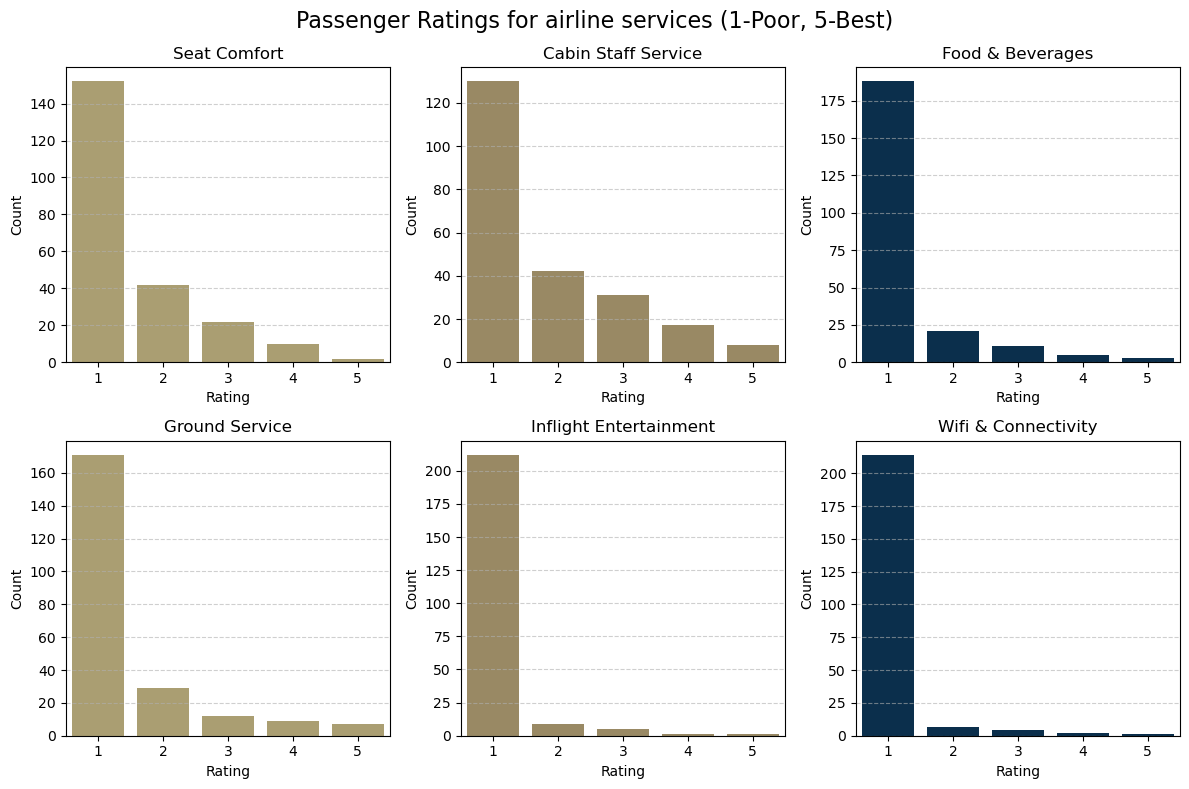

In [97]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Flatten the axs array to loop through
axs = axs.flatten()

pass_review_df = ryan_pas_review_df[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']].dropna().astype(int)
# Plot count plots for each column
for i, column in enumerate(pass_review_df.columns):
    if i < 3:
        color_choice = gtech_palette[i]
    else:
        color_choice = gtech_palette[i-3]
    sns.countplot(x=column, data=pass_review_df, ax=axs[i], color=color_choice)
    axs[i].set_title(column)
    axs[i].set_xlabel('Rating')
    axs[i].set_ylabel('Count')
    axs[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Passenger Ratings for airline services (1-Poor, 5-Best)', fontsize=16)
plt.tight_layout()
plt.show()

## Visualize the distribution of sentiments (positive, negative, neutral) in the dataset using bar plots or pie charts.

In [104]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [105]:
def get_sentiment(text):
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe("spacytextblob")
    doc = nlp(text)

    if doc._.blob.polarity > 0:
        return (round(doc._.blob.polarity, 2), "Positive")
    elif doc._.blob.polarity < 0:
        return (round(doc._.blob.polarity, 2), "Negative")
    else:
        return (round(doc._.blob.polarity, 2), "Neutral")

get_sentiment(ryan_pas_review_df['Comment'].iloc[6])

(-0.11, 'Negative')

In [106]:
%time
# test_df = ryan_pas_review_df[['Comment']].head(20).copy()
ryan_pas_review_df['Sentiments'] = ryan_pas_review_df['Comment'].apply(lambda x: get_sentiment(x))
ryan_pas_review_df[['Polarity Score', 'Sentiment']] = ryan_pas_review_df['Sentiments'].apply(lambda x: pd.Series(x))
ryan_pas_review_df.head(10)

CPU times: total: 0 ns
Wall time: 0 ns


,Unnamed: 0,Date Published,Overall Rating,Passenger Country,Trip_verified,Comment title,Comment,Aircraft,Type Of Traveller,Seat Type,...,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity,Sentiments,Polarity Score,Sentiment
0,0,2024-02-03,10.0,United Kingdom,Not Verified,"""bang on time and smooth flights""",Flew back from Faro to London Luton Friday 2nd...,Boeing 737 900,Family Leisure,Economy Class,...,5.0,3.0,4.0,4.0,yes,NaN,NaN,"(0.2, Positive)",0.20,Positive
1,1,2024-01-26,10.0,United Kingdom,Trip Verified,"""Another good affordable flight""",Another good affordable flight with Ryanair. O...,NaN,Couple Leisure,Economy Class,...,5.0,3.0,5.0,5.0,yes,NaN,NaN,"(0.56, Positive)",0.56,Positive
2,2,2024-01-20,10.0,United Kingdom,Trip Verified,“Really impressed!”,"Really impressed! You get what you pay for, th...",Boeing 737-800,Couple Leisure,Economy Class,...,5.0,4.0,5.0,5.0,yes,NaN,NaN,"(0.37, Positive)",0.37,Positive
3,3,2024-01-07,6.0,United Kingdom,Trip Verified,“a decent offering from Ryanair”,I should like to review my flight from Faro to...,Boeing 737,Solo Leisure,Economy Class,...,2.0,1.0,3.0,3.0,yes,NaN,NaN,"(0.06, Positive)",0.06,Positive
4,4,2024-01-06,10.0,Israel,Trip Verified,“cabin crew were welcoming and friendly”,"Flight left the gate ahead of schedule, fare w...",Boeing 737-800,Solo Leisure,Economy Class,...,5.0,NaN,4.0,5.0,yes,NaN,NaN,"(0.3, Positive)",0.30,Positive
5,5,2024-01-06,1.0,Denmark,Not Verified,"""close online checkin 3 hours before""",Booked a fight from Copenhagen to Poland thoug...,NaN,Solo Leisure,Economy Class,...,2.0,2.0,1.0,1.0,no,2.0,2.0,"(0.09, Positive)",0.09,Positive
6,6,2024-01-03,5.0,United Kingdom,Not Verified,"""they are really not better value""",The flight itself is operated by Malta air and...,Boeing 737,Business,Economy Class,...,5.0,2.0,1.0,1.0,yes,NaN,NaN,"(-0.11, Negative)",-0.11,Negative
7,7,2024-01-03,1.0,Australia,Trip Verified,"""asked me to pay for the backpack""","Staff is rude and has no manners, let alone be...",NaN,Solo Leisure,Economy Class,...,NaN,NaN,1.0,1.0,no,NaN,NaN,"(0.04, Positive)",0.04,Positive
8,8,2023-12-25,1.0,United Kingdom,Trip Verified,"""ground service staff is really bad""",Ryanair ground service staff is really bad. If...,NaN,Family Leisure,Economy Class,...,NaN,NaN,1.0,1.0,no,NaN,NaN,"(-0.7, Negative)",-0.70,Negative
9,9,2023-12-08,1.0,Germany,Not Verified,"""they made us pay a No show fee""",I wanted to check in online a night before our...,NaN,Couple Leisure,Economy Class,...,1.0,NaN,1.0,1.0,no,NaN,NaN,"(-0.15, Negative)",-0.15,Negative


In [107]:
ryan_pas_review_df.to_csv('./data/ryanair_reviews_sentiments_v1.csv', index=False)

In [108]:
ryan_pas_review_df = pd.read_csv('./data/ryanair_reviews_sentiments_v1.csv')
ryan_pas_review_df.shape

(2249, 24)

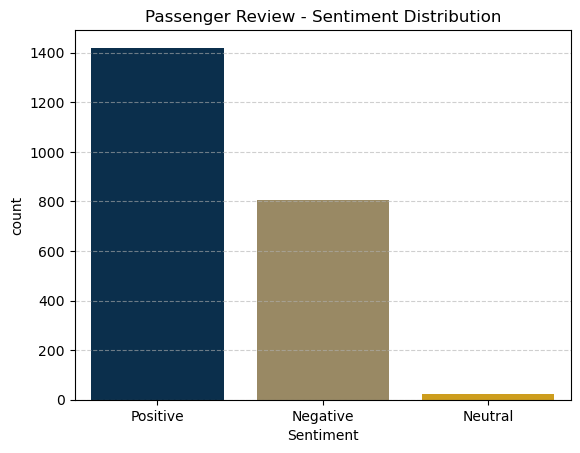

In [109]:
# Define your colors
colors = ['#003057', '#A28D5B', '#EAAA00']
sns.countplot(x='Sentiment', data=ryan_pas_review_df, palette=colors)
plt.title('Passenger Review - Sentiment Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Investigate the distribution of review lengths (number of words or characters) for each sentiment category. This can help identify if sentiment varies        based on the length of the review

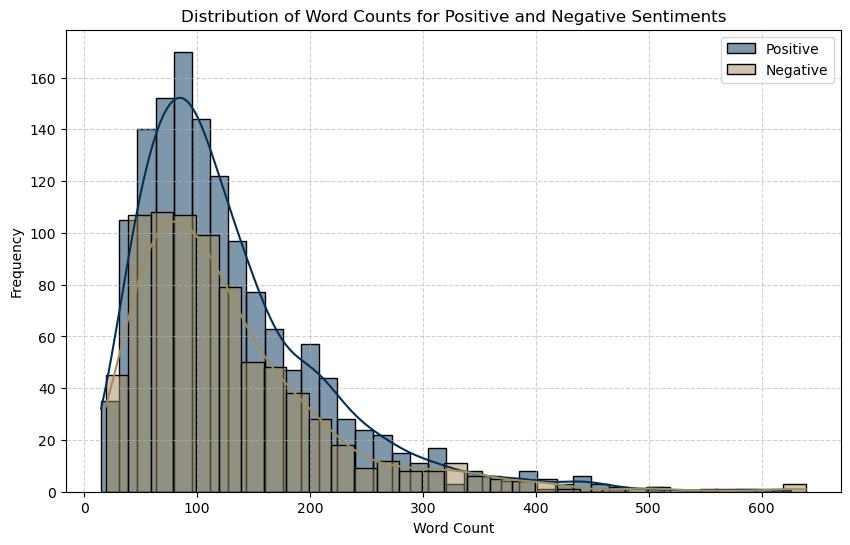

In [110]:
# Calculate word count for each review
ryan_pas_review_df['WordCount'] = ryan_pas_review_df['Comment'].apply(lambda x: len(x.split()))

# Separate positive and negative sentiment reviews
positive_reviews = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Positive']
negative_reviews = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative']
# Plot the distribution of word counts for positive and negative sentiment reviews
plt.figure(figsize=(10, 6))
sns.histplot(positive_reviews['WordCount'], color='#003057', label='Positive', kde=True)
sns.histplot(negative_reviews['WordCount'], color='#A28D5B', label='Negative', kde=True)
plt.title('Distribution of Word Counts for Positive and Negative Sentiments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## Analyze how sentiment varies over time. Plotting sentiment trends over time can reveal seasonal patterns or changes in sentiment trends.

In [117]:
# Negative sentiments by Year
ryan_pas_review_df['Date Published'] = pd.to_datetime(ryan_pas_review_df['Date Published'])
ryan_pas_review_df['Year'] = ryan_pas_review_df['Date Published'].dt.year
ryan_pas_review_df['Month'] = ryan_pas_review_df['Date Published'].dt.month_name()

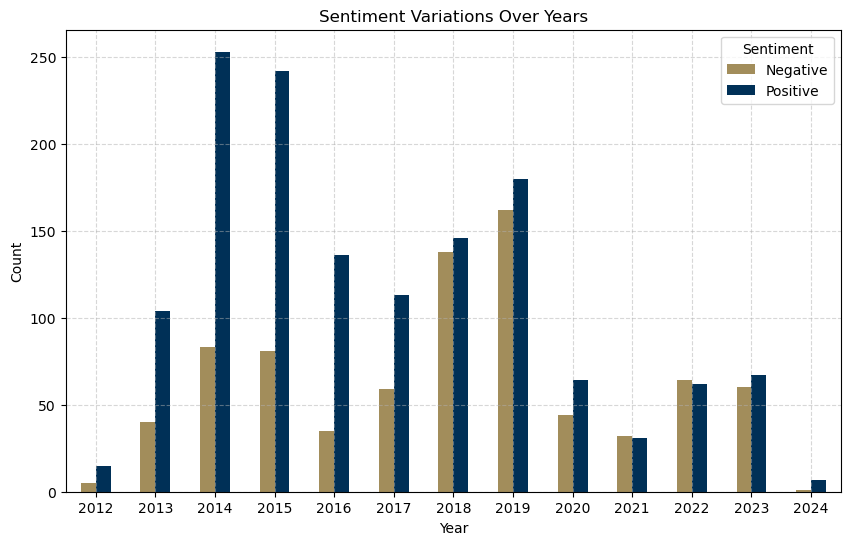

In [113]:
# Count positive and negative sentiment occurrences for each year
sentiment_counts = ryan_pas_review_df[ryan_pas_review_df.Sentiment.isin(['Positive', 'Negative'])].groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

# Plot grouped bar chart
sentiment_counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#A28D5B', '#003057'])
plt.title('Sentiment Variations Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [122]:
# sentiment_counts['Month_Num'] = sentiment_counts.index.Month
sentiment_counts

Sentiment,Negative,Positive
Month,,
April,56,108
August,74,139
December,55,93
February,42,95
January,53,88
July,100,119
June,63,109
March,44,83
May,68,116


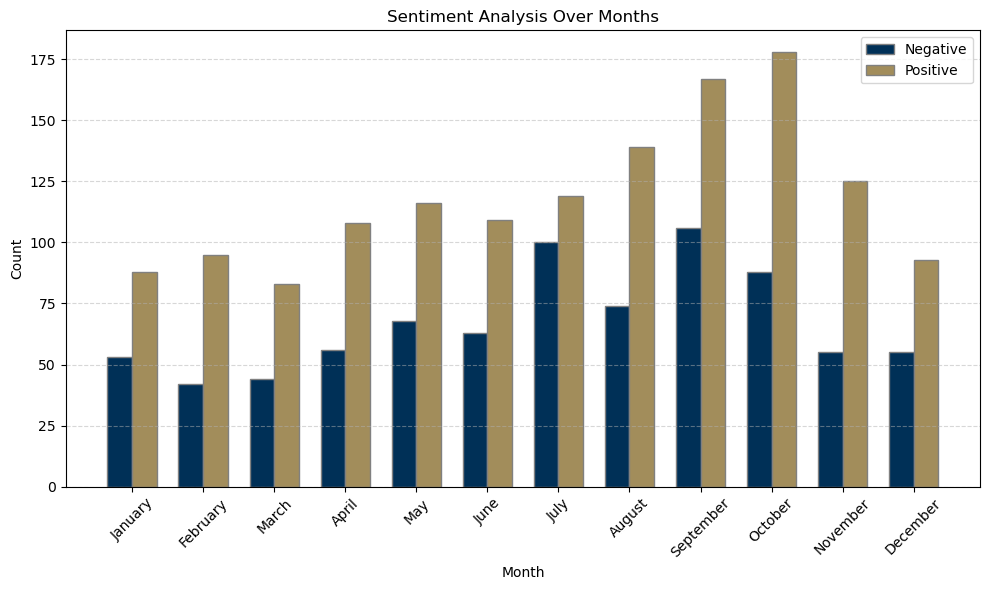

In [130]:
# Define the data
monthly_data = {
    'Month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    'Negative': [53, 42, 44, 56, 68, 63, 100, 74, 106, 88, 55, 55],
    'Positive': [88, 95, 83, 108, 116, 109, 119, 139, 167, 178, 125, 93]
}

# Create a pandas DataFrame
monthly_df = pd.DataFrame(monthly_data)

bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(monthly_df['Month']))
r2 = [x + bar_width for x in r1]

# Plot the side-by-side bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, monthly_df['Negative'], color='#003057', width=bar_width, edgecolor='grey', label='Negative')
plt.bar(r2, monthly_df['Positive'], color='#A28D5B', width=bar_width, edgecolor='grey', label='Positive')
plt.title('Sentiment Analysis Over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks([r + bar_width/2 for r in range(len(monthly_df['Month']))], monthly_df['Month'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

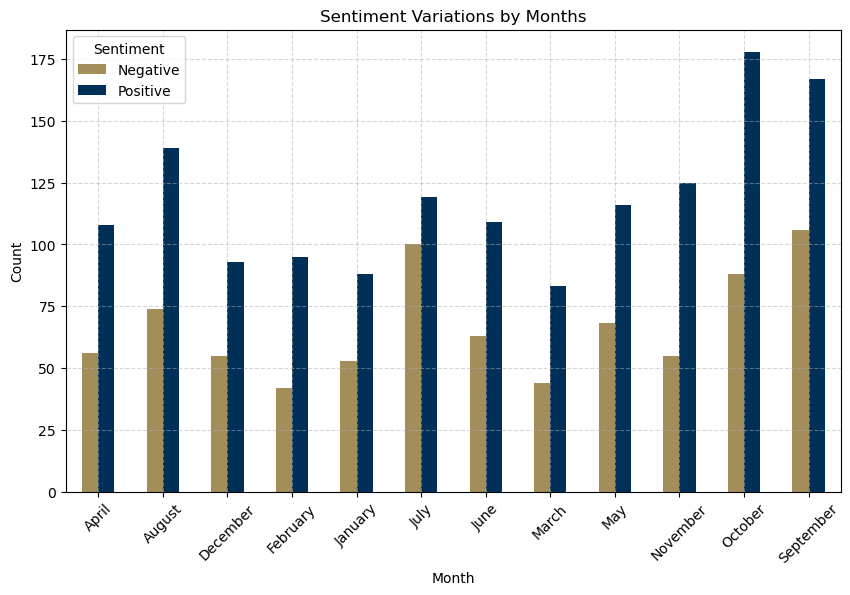

In [118]:
# Count positive and negative sentiment occurrences for each year
sentiment_counts = ryan_pas_review_df[ryan_pas_review_df.Sentiment.isin(['Positive', 'Negative'])].groupby(['Month', 'Sentiment']).size().unstack(fill_value=0)

# Plot grouped bar chart
sentiment_counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#A28D5B', '#003057'])
plt.title('Sentiment Variations by Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

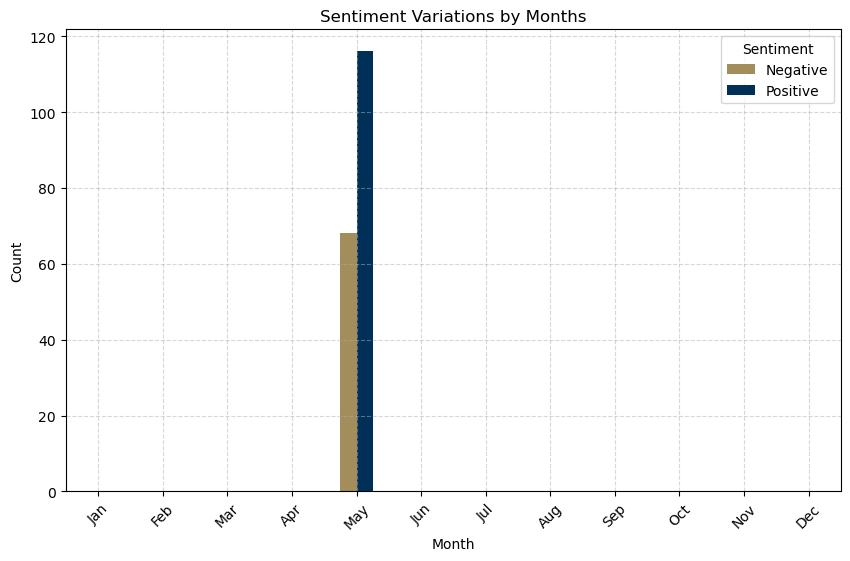

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the order of months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Convert 'Month' column to categorical with specified order
ryan_pas_review_df['Month'] = pd.Categorical(ryan_pas_review_df['Month'], categories=month_order, ordered=True)

# Count positive and negative sentiment occurrences for each year
sentiment_counts = ryan_pas_review_df[ryan_pas_review_df.Sentiment.isin(['Positive', 'Negative'])].groupby(['Month', 'Sentiment']).size().unstack(fill_value=0)

# Plot grouped bar chart
sentiment_counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#A28D5B', '#003057'])
plt.title('Sentiment Variations by Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment')
plt.grid(linestyle='--', alpha=0.5)
plt.show()


## Explore the most frequent words or phrases used in the reviews (word clouds, frequency plots, etc.)

In [14]:

negative_sentences = []
polarity_scores = []

def find_negative_reviews(text):
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe("spacytextblob")
    doc = nlp(text)

    for sentence in doc.sents:
        
        if sentence._.blob.polarity <= -0.40:
            # print(sentence, sentence._.blob.polarity)
            negative_sentences.append(sentence.text)
            polarity_scores.append(sentence._.blob.polarity)

# Filter rows with negative sentiment
negative_df = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative'][['Comment', 'Comment title']]
negative_df['Overall_Comment'] = negative_df['Comment title'] + ' ' + negative_df['Comment']

# Extract text from the negative sentiment rows
negative_text = ' '.join(negative_df['Overall_Comment'])

find_negative_reviews(negative_text)
negative_reviews_df = pd.DataFrame({'Negative Sentences': negative_sentences, 'Polarity Score': polarity_scores})
negative_reviews_df

,Negative Sentences,Polarity Score
0,Like they hate their work.,-0.800
1,Cabins are not the worst that I've been on.,-1.000
2,I'm a wee guy so 2hrs 30mins isn't too bad.,-0.700
3,"""ground service staff is really bad"" Ryanair g...",-0.700
4,Too bad if you ignored the email.,-0.700
...,...,...
902,Terrible experience never again!,-1.000
903,Stick within the rules and its not all that bad!,-0.875
904,Ryanair customer review Stansted to Pula. Trie...,-0.500
905,Erroneously assumed outbound copies and itiner...,-0.500


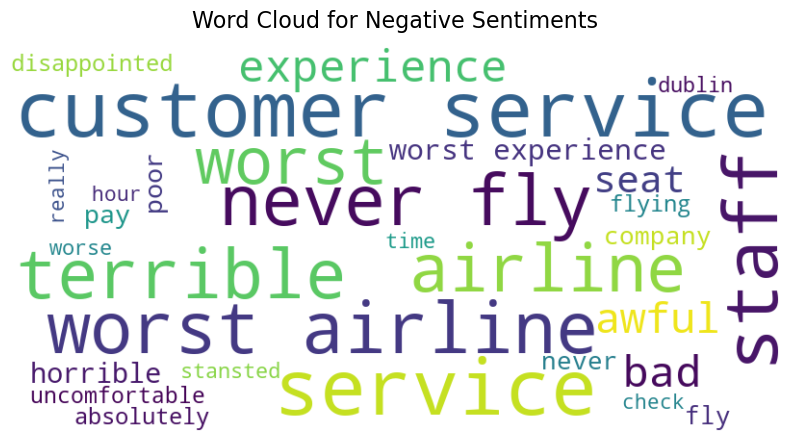

In [15]:
# Filter rows with negative sentiment
negative_df = negative_reviews_df[['Negative Sentences']]

# Extract text from the negative sentiment rows
negative_text = ' '.join(negative_df['Negative Sentences'])

# Lemmatize the text
negative_text = lemmatizer.lemmatize(negative_text)

# Tokenize and preprocess the text
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = set(['ryanair', 'flight', 'airport', 'us', 'one', 'airline' 'would','get','told', 'could', 'even', 'got', 'also', 'another', 'ever', 'like', 'way', 'go', 'asked', 'every', '2', 'plane'])
stop_word = stop_words.union(custom_stopwords)

tokens = word_tokenize(negative_text)
filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_word]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=30, colormap = 'viridis_r', repeat=False, normalize_plurals = True).generate(' '.join(filtered_tokens))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud for Negative Sentiment')
plt.text(0.5, 1.05, 'Word Cloud for Negative Sentiments',
         horizontalalignment='center', fontsize=16, transform=plt.gca().transAxes)
plt.show()

## Analyze the route showing most negative feedbacks.

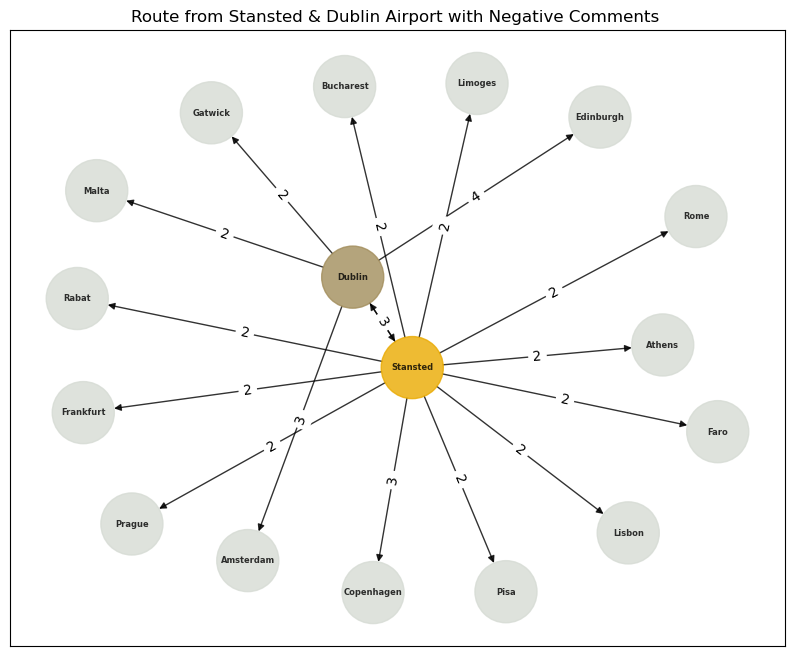

In [16]:
route_neg_comment_df = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative'][['Origin', 'Destination']]\
                            .groupby(['Origin', 'Destination'])\
                            .size()\
                            .reset_index(name='Count')\
                            .sort_values('Count', ascending=False)\

stansted_df = route_neg_comment_df[(route_neg_comment_df['Origin'].isin(['Dublin', 'Stansted']) & (route_neg_comment_df['Count'] > 1))]
							
# Define colors for each origin
colors = {'Stansted': 'green', 'Dublin': 'blue', 'Barcelona': 'yellow'}
color_map = ['green', 'blue', 'yellow']

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in stansted_df.iterrows():
    G.add_edge(row['Origin'], row['Destination'], weight=row['Count'])

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.60)  # Positions for all nodes
nx.draw_networkx(G, pos, with_labels=True, node_size=2000, font_size=6, font_weight="bold", arrowsize=10, alpha=0.8, node_color=["#EAAA00" if node == 'Stansted' else '#A28D5B' if node == 'Dublin' else '#D6DBD4' for node in G.nodes()])
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Route from Stansted & Dublin Airport with Negative Comments ', size=12)
plt.show()

## Explore word associations or co-occurrences within each sentiment category. Identify words that frequently appear together with positive or negative sentiments, which can provide insights into the language used by customers.


In [17]:
# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuations = set(punctuation)

# Function to preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\d+', '', ''.join([c for c in text if c not in punctuations]))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Tokenize, preprocess and perform bigram analysis
all_tokens = [preprocess_text(review) for review in negative_reviews_df['Negative Sentences']]
tokens_flat = [token for sublist in all_tokens for token in sublist]
bi_grams = list(bigrams(tokens_flat))
bi_grams_count = Counter(bi_grams)

# Sort the bigrams by frequency in descending order
sorted_bigrams = bi_grams_count.most_common()

# Print the sorted bigrams
for bigram, count in sorted_bigrams:
    print(f"{bigram}: {count}")

('customer', 'service'): 76
('never', 'fly'): 64
('worst', 'airline'): 61
('fly', 'ryanair'): 42
('airline', 'ever'): 34
('worst', 'experience'): 26
('ryanair', 'worst'): 19
('worst', 'customer'): 19
('terrible', 'experience'): 19
('ryanair', 'customer'): 16
('bad', 'experience'): 15
('terrible', 'service'): 15
('ever', 'flown'): 15
('terrible', 'customer'): 15
('fly', 'airline'): 14
('customer', 'review'): 14
('horrible', 'experience'): 13
('experience', 'ever'): 12
('experience', 'worst'): 11
('experience', 'ryanair'): 11
('’', 'ever'): 10
('worst', 'ever'): 10
('boarding', 'passes'): 10
('one', 'worst'): 9
('flying', 'ryanair'): 9
('seats', 'uncomfortable'): 9
('cabin', 'crew'): 9
('flight', 'worst'): 8
('ever', 'worst'): 8
('service', 'ever'): 8
('terrible', 'airline'): 8
('worst', 'flight'): 8
('awful', 'experience'): 7
('horrible', 'airline'): 7
('never', 'use'): 7
('service', 'terrible'): 7
('ryanair', 'staff'): 7
('service', 'never'): 7
('bad', 'customer'): 7
('flight', 'delaye

In [18]:
pd.DataFrame(sorted_bigrams, columns=['Bigram', 'Count']).head(10)

,Bigram,Count
0,"(customer, service)",76
1,"(never, fly)",64
2,"(worst, airline)",61
3,"(fly, ryanair)",42
4,"(airline, ever)",34
5,"(worst, experience)",26
6,"(ryanair, worst)",19
7,"(worst, customer)",19
8,"(terrible, experience)",19
9,"(ryanair, customer)",16


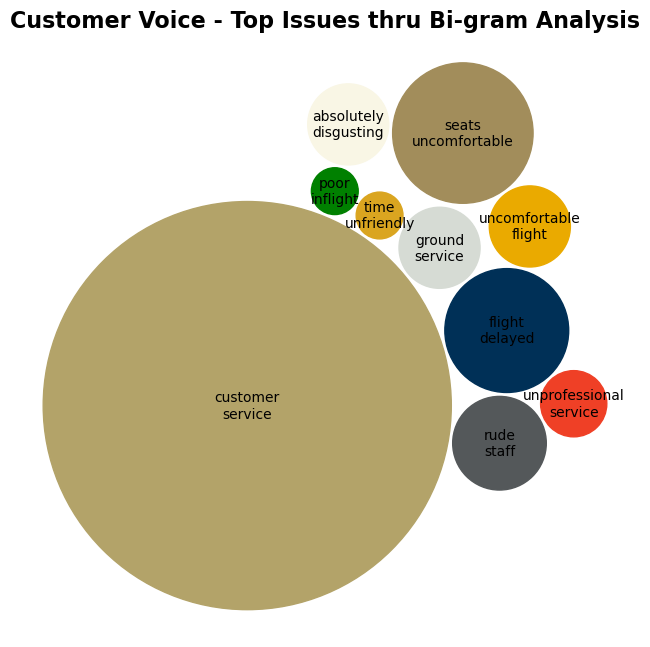

In [19]:
data = {
    'bigrams': ['customer\nservice', 'seats\nuncomfortable', 'flight\ndelayed', 'rude\nstaff', 'ground\nservice', 'absolutely\ndisgusting', 'uncomfortable\nflight', 
                'unprofessional\nservice', 'time\nunfriendly', 'poor\ninflight'],
    'frequency': [76, 9, 7, 4, 3, 3, 3, 2, 1, 1],
    'color': ['#B3A369', '#A28D5B', '#003057', '#54585A', '#D6DBD4', '#F9F6E5', '#EAAA00', '#EF4026',
              'goldenrod','green']}
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=data['frequency'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, data['bigrams'], data['color'])
ax.figure.set_size_inches(8, 8)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Customer Voice - Top Issues thru Bi-gram Analysis', fontsize=16, fontweight='bold')
plt.show()

## Topic Modelling

In [23]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 

In [48]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove punctuation, stopwords, and lemmatize
def process_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Remove numbers and special characters
    tokens = [word for word in tokens if word.isalpha()]
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

In [49]:
#tokenize articles
# tokeize_article = negative_text.split()
# tokeize_article
# filtered_tokens
tokenize_article = negative_df['Negative Sentences'].apply(lambda x : process_text(x))

# tokenize_article = negative_df['Cleaned Sentences'].apply(lambda x : x.split())
id2word = corpora.Dictionary(tokenize_article)

# # Create Corpus
# texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tokenize_article]
corpus

#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[('Like', 1), ('hate', 1), ('work', 1)]

In [69]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           eta = 'auto')

In [70]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.084*"staff" + 0.039*"poor" + 0.030*"could" + 0.030*"disappointed" + '
  '0.027*"flight" + 0.021*"unhappy" + 0.020*"awful" + 0.020*"go" + '
  '0.020*"make" + 0.018*"told"'),
 (1,
  '0.059*"worse" + 0.043*"awful" + 0.027*"got" + 0.022*"get" + 0.020*"could" + '
  '0.019*"something" + 0.016*"tired" + 0.014*"bag" + 0.013*"frustrated" + '
  '0.013*"situation"'),
 (2,
  '0.077*"seat" + 0.040*"Stansted" + 0.037*"uncomfortable" + 0.034*"return" + '
  '0.023*"fee" + 0.023*"holiday" + 0.022*"flight" + 0.020*"miserable" + '
  '0.016*"paid" + 0.014*"Flew"'),
 (3,
  '0.148*"service" + 0.126*"customer" + 0.038*"review" + 0.035*"Terrible" + '
  '0.031*"terrible" + 0.029*"cabin" + 0.022*"Dublin" + 0.021*"unable" + '
  '0.019*"around" + 0.015*"uncomfortable"'),
 (4,
  '0.030*"take" + 0.024*"online" + 0.024*"would" + 0.021*"ticket" + '
  '0.020*"charged" + 0.019*"check" + 0.018*"difficult" + 0.017*"bag" + '
  '0.017*"line" + 0.015*"member"'),
 (5,
  '0.140*"experience" + 0.036*"terrible" + 0.03

In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.170659 -0.001309       1        1  15.641017
5      0.191570 -0.054884       2        1  14.847490
3     -0.137583 -0.327724       3        1  13.579146
0     -0.081900  0.089891       4        1  11.402986
6     -0.112267  0.117949       5        1  11.283251
8      0.212905 -0.016377       6        1   9.478722
4     -0.050279  0.074450       7        1   7.115165
2     -0.095534  0.037940       8        1   6.788841
1     -0.078629  0.023063       9        1   5.247569
7     -0.018943  0.057002      10        1   4.615814, topic_info=           Term        Freq       Total Category  logprob  loglift
11      service  110.000000  110.000000  Default  30.0000  30.0000
17   experience  113.000000  113.000000  Default  29.0000  29.0000
75     customer   94.000000   94.000000  Default  28.0000  28.0000
8       Ryanair  172.000000  172.000000  Default  27.0000  27.0000
68      airline   89.000000   89.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
345      policy    3.262347    4.867467  Topic10  -4.3441   2.6756
991    dreadful    3.164092    5.300889  Topic10  -4.3747   2.5597
155        rude    4.827027   12.931709  Topic10  -3.9524   2.0902
46       flight    9.054564   86.835155  Topic10  -3.3233   0.8149
4         worst    5.122942   92.457835  Topic10  -3.8929   0.1827

[413 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
405       2  0.925124  Absolutely
37        5  0.912959      Athens
527       1  0.963187       Awful
1383     10  0.815581        Baby
579       6  0.932415   Barcelona
...     ...       ...         ...
4        10  0.054079       worst
92        5  0.470188       would
92        7  0.470188       would
426       2  0.991259       wrong
882       1  0.825634        year

[426 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 4, 1, 7, 9, 5, 3, 2, 8])

In [86]:
vis.token_table.sort_values('Topic', ascending=True)

,Topic,Freq,Term
term,,,
882,1,0.825634,year
713,1,0.958828,print
8,1,0.760618,Ryanair
49,1,0.153190,pay
306,1,0.905474,passenger
...,...,...,...
655,10,0.867072,due
991,10,0.565943,dreadful
1372,10,0.815632,distraught


In [57]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -7.029428659388914

Coherence Score:  0.40745721036856236


In [58]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

n : 2 ; alpha : symmetric ; beta : auto ; Score : 0.35621237768080133
n : 2 ; alpha : symmetric ; beta : 0.3 ; Score : 0.3373069415522486
n : 2 ; alpha : symmetric ; beta : 0.5 ; Score : 0.35621237768080133
n : 2 ; alpha : symmetric ; beta : 0.7 ; Score : 0.3409002655402701
n : 2 ; alpha : 0.3 ; beta : auto ; Score : 0.3382848019357527
n : 2 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.29671377767053675
n : 2 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.3382848019357527
n : 2 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.35748774608091904
n : 2 ; alpha : 0.5 ; beta : auto ; Score : 0.35621237768080133
n : 2 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.3373069415522486
n : 2 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.35621237768080133
n : 2 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.3409002655402701
n : 2 ; alpha : 0.7 ; beta : auto ; Score : 0.31254668441376543
n : 2 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.31097203086957215
n : 2 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.31254668441376543
n : 2 ; alpha : 0.7 ; beta : 0.7 

# Appendix

<Axes: xlabel='Overall Rating'>

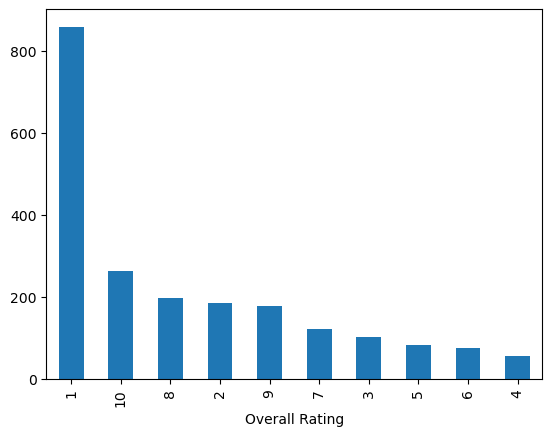

In [90]:
ryan_pas_review_df['Overall Rating'].dropna().astype(int).value_counts().plot(kind='bar')

<Axes: xlabel='Recommended'>

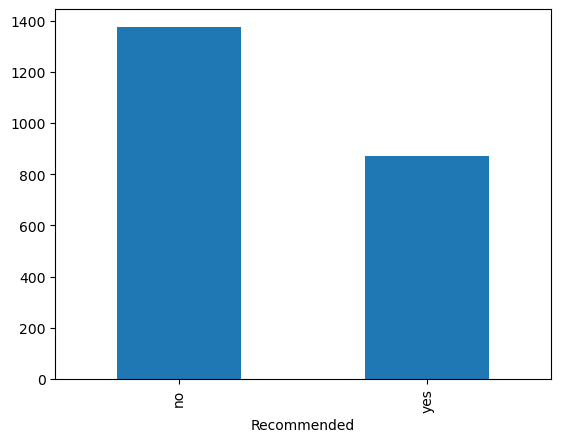

In [91]:
ryan_pas_review_df['Recommended'].value_counts().plot(kind='bar')

Word Cloud for Negative Sentiments

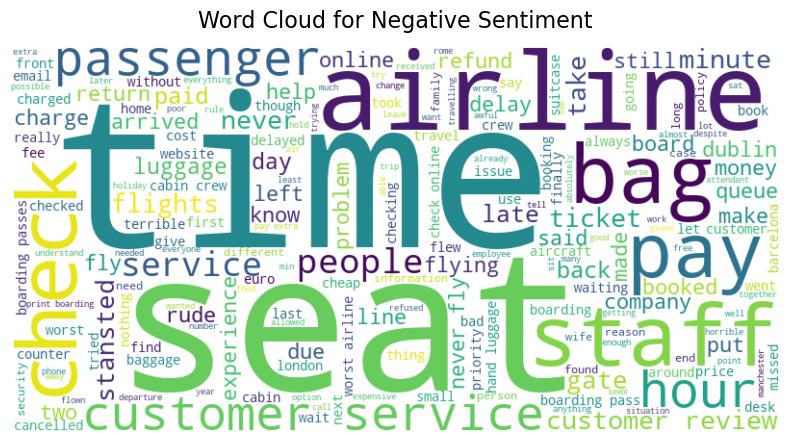

In [13]:
# Filter rows with negative sentiment
negative_df = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative'][['Comment', 'Comment title']]
negative_df['Overall_Comment'] = negative_df['Comment title'] + ' ' + negative_df['Comment']

# Extract text from the negative sentiment rows
negative_text = ' '.join(negative_df['Overall_Comment'])

# Lemmatize the text
negative_text = lemmatizer.lemmatize(negative_text)

# Tokenize and preprocess the text
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = set(['ryanair', 'flight', 'airport', 'us', 'one', 'airline' 'would','get','told', 'could', 'even', 'got', 'also', 'another', 'ever', 'like', 'way', 'go', 'asked', 'every', '2', 'plane'])
stop_words = stop_words.union(custom_stopwords)

tokens = word_tokenize(negative_text)
filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud for Negative Sentiment')
plt.text(0.5, 1.05, 'Word Cloud for Negative Sentiment',
         horizontalalignment='center', fontsize=16, transform=plt.gca().transAxes)
plt.show()

###Conduct word frequency analysis to identify common words in reviews.

In [14]:
# Count the frequency of each word
word_freq = Counter(filtered_tokens)

# Identify the most impactful words based on frequency
most_common_words = word_freq.most_common(50)  # Change 10 to the number of most common words you want to analyze
most_common_words

[('customer', 440),
 ('check', 420),
 ('airline', 417),
 ('pay', 397),
 ('staff', 394),
 ('service', 393),
 ('boarding', 384),
 ('time', 384),
 ('never', 321),
 ('would', 306),
 ('seats', 237),
 ('luggage', 237),
 ('hours', 230),
 ('experience', 223),
 ('bag', 208),
 ('extra', 208),
 ('worst', 206),
 ('fly', 198),
 ('cabin', 194),
 ('online', 193),
 ('people', 189),
 ('back', 187),
 ('review', 187),
 ('hour', 185),
 ('minutes', 184),
 ('late', 180),
 ('stansted', 179),
 ('gate', 177),
 ('flights', 172),
 ('seat', 172),
 ('paid', 171),
 ('rude', 166),
 ('passengers', 165),
 ('money', 164),
 ('crew', 160),
 ('take', 152),
 ('flying', 139),
 ('board', 133),
 ('made', 130),
 ('return', 130),
 ('said', 128),
 ('arrived', 128),
 ('ticket', 127),
 ('bad', 126),
 ('due', 126),
 ('two', 126),
 ('last', 125),
 ('bags', 125),
 ('baggage', 121),
 ('delayed', 120)]

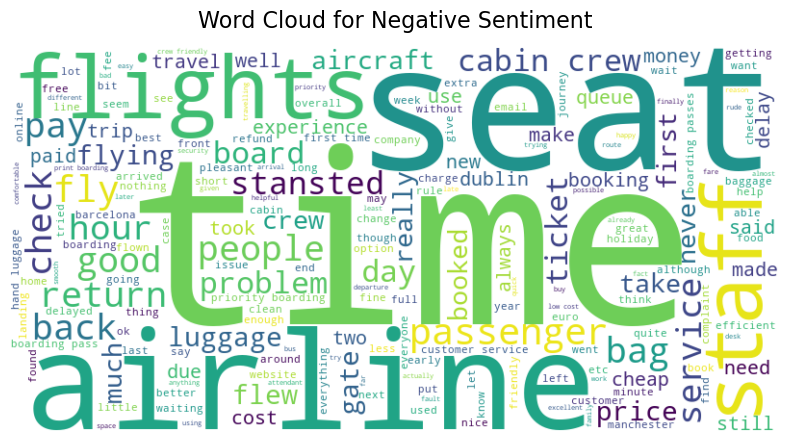

In [15]:
# Filter rows with negative sentiment
positive_df = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Positive'][['Comment', 'Comment title']]
positive_df['Overall_Comment'] = positive_df['Comment title'] + ' ' + positive_df['Comment']

# Extract text from the negative sentiment rows
positive_text = ' '.join(positive_df['Comment'])

# Lemmatize the text
positive_text = lemmatizer.lemmatize(positive_text)

# Tokenize and preprocess the text
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = set(['ryanair', 'flight', 'airport', 'us', 'one', 'airline' 'would','get','told', 'could', 'even', 'got', 'also', 'another', 'ever', 'like', 'way', 'go', 'asked', 'every', '2', 'plane'])
stop_words = stop_words.union(custom_stopwords)

tokens = word_tokenize(positive_text)
filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud for Negative Sentiment')
plt.text(0.5, 1.05, 'Word Cloud for Negative Sentiment',
         horizontalalignment='center', fontsize=16, transform=plt.gca().transAxes)
plt.show()

In [16]:
# Count the frequency of each word
word_freq = Counter(filtered_tokens)

# Identify the most impactful words based on frequency
most_common_words = word_freq.most_common(50)  # Change 10 to the number of most common words you want to analyze
most_common_words

[('time', 949),
 ('boarding', 747),
 ('would', 622),
 ('crew', 570),
 ('staff', 563),
 ('flights', 533),
 ('airline', 510),
 ('seats', 494),
 ('pay', 492),
 ('check', 473),
 ('cabin', 462),
 ('service', 433),
 ('luggage', 423),
 ('fly', 416),
 ('good', 402),
 ('back', 394),
 ('return', 387),
 ('seat', 379),
 ('people', 360),
 ('stansted', 335),
 ('passengers', 322),
 ('first', 315),
 ('extra', 306),
 ('minutes', 298),
 ('never', 294),
 ('bag', 286),
 ('hours', 281),
 ('priority', 279),
 ('money', 264),
 ('paid', 257),
 ('flew', 256),
 ('board', 256),
 ('much', 252),
 ('friendly', 251),
 ('arrived', 248),
 ('online', 245),
 ('flying', 238),
 ('cost', 237),
 ('price', 237),
 ('gate', 236),
 ('experience', 229),
 ('use', 219),
 ('hour', 216),
 ('booked', 214),
 ('really', 213),
 ('customer', 208),
 ('aircraft', 208),
 ('take', 207),
 ('cheap', 206),
 ('dublin', 206)]

### 4. Analyze how sentiment varies over time. Plotting sentiment trends over time can reveal seasonal patterns or changes in sentiment trends.

In [17]:
# Negative sentiments by Year
ryan_pas_review_df['Date Published'] = pd.to_datetime(ryan_pas_review_df['Date Published'])
ryan_pas_review_df['Year'] = ryan_pas_review_df['Date Published'].dt.year
ryan_pas_review_df['Month'] = ryan_pas_review_df['Date Published'].dt.month_name()

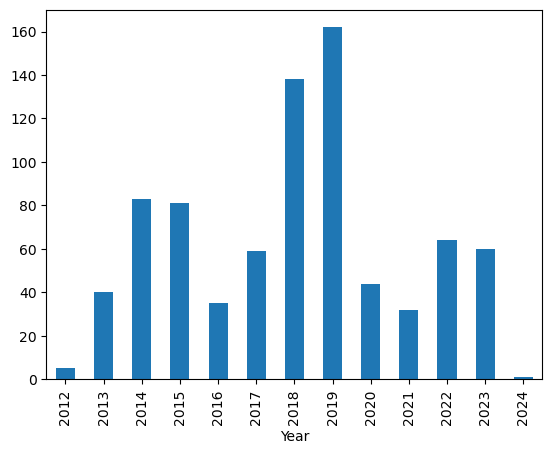

In [18]:
neg_sent_by_year = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative'].groupby('Year').size().plot(kind='bar')

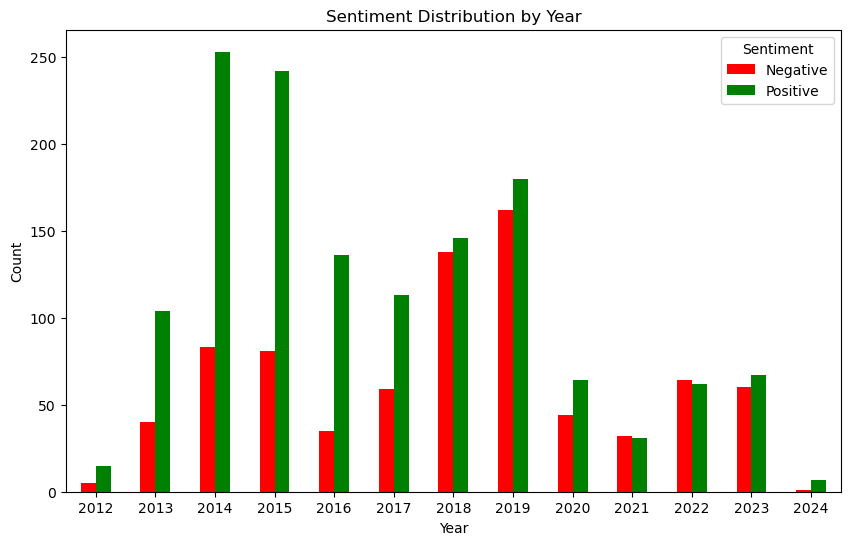

In [19]:
# Count positive and negative sentiment occurrences for each year
sentiment_counts = ryan_pas_review_df[ryan_pas_review_df.Sentiment.isin(['Positive', 'Negative'])].groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

# Plot grouped bar chart
sentiment_counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['red', 'green'])
plt.title('Sentiment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()

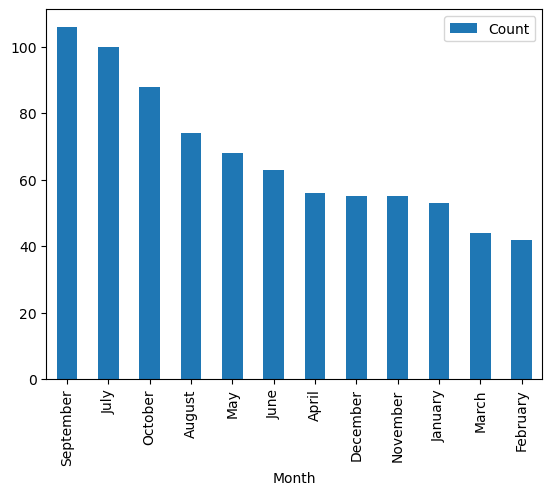

In [20]:
neg_sent_by_year = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative'].groupby('Month').size().reset_index(name='Count').sort_values('Count', ascending=False).plot(kind='bar', x='Month', y='Count')

### Explore the distribution of review ratings.

In [21]:
# Calculate word count for each review
ryan_pas_review_df['WordCount'] = ryan_pas_review_df['Comment'].apply(lambda x: len(x.split()))

c:\Users\jagan\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jagan\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jagan\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jagan\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

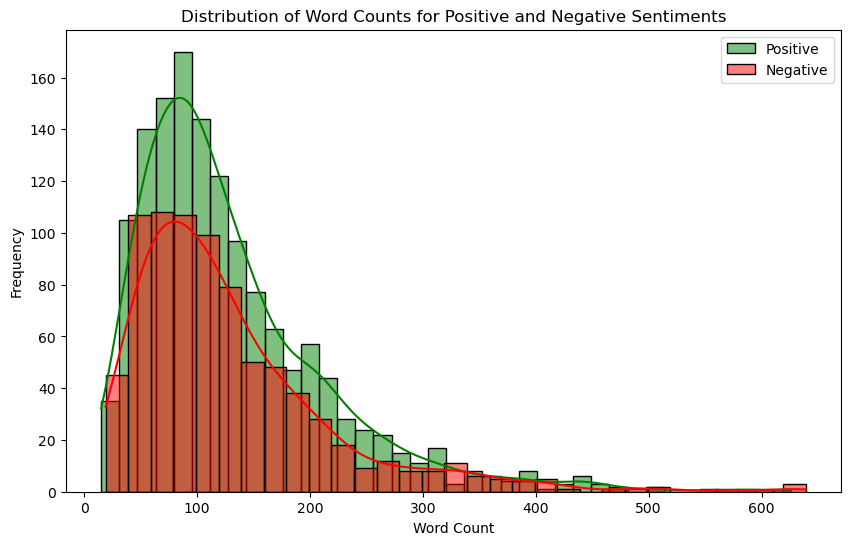

In [22]:
# Separate positive and negative sentiment reviews
positive_reviews = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Positive']
negative_reviews = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative']
# Plot the distribution of word counts for positive and negative sentiment reviews
plt.figure(figsize=(10, 6))
sns.histplot(positive_reviews['WordCount'], color='green', label='Positive', kde=True)
sns.histplot(negative_reviews['WordCount'], color='red', label='Negative', kde=True)
plt.title('Distribution of Word Counts for Positive and Negative Sentiments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Which Route has most negative comments ?

In [23]:
route_neg_comment_df.groupby('Origin').size().reset_index(name='Count').sort_values('Count', ascending=False)

NameError: name 'route_neg_comment_df' is not defined

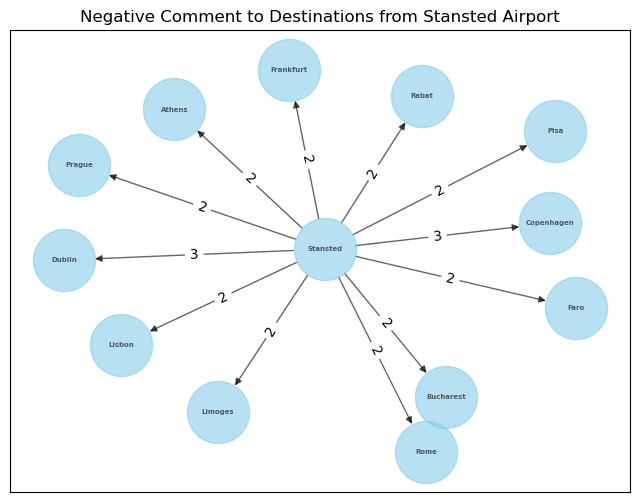

In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
route_neg_comment_df = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative'][['Origin', 'Destination']]\
                            .groupby(['Origin', 'Destination'])\
                            .size()\
                            .reset_index(name='Count')\
                            .sort_values('Count', ascending=False)\

stansted_df = route_neg_comment_df[(route_neg_comment_df['Origin']=='Stansted') & (route_neg_comment_df['Count'] > 1)]

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in stansted_df.iterrows():
    G.add_edge(row['Origin'], row['Destination'], weight=row['Count'])

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw_networkx(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=5, font_weight="bold", arrowsize=10, alpha=0.6)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Negative Comment to Destinations from Stansted Airport', size=12)
plt.show()

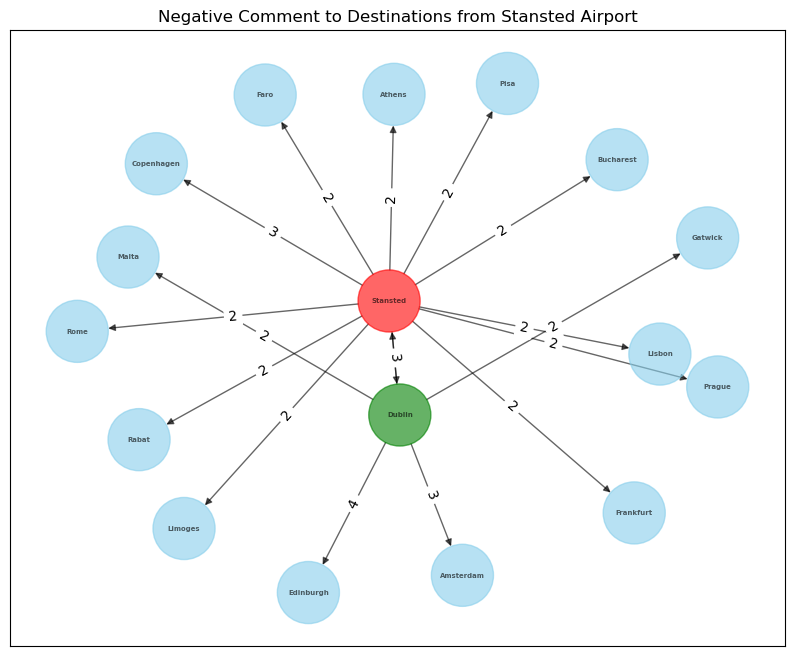

In [25]:
stansted_df = route_neg_comment_df[(route_neg_comment_df['Origin'].isin(['Dublin', 'Stansted']) & (route_neg_comment_df['Count'] > 1))]

# Define colors for each origin
colors = {'Stansted': 'green', 'Dublin': 'blue', 'Barcelona': 'yellow'}
color_map = ['green', 'blue', 'yellow']

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in stansted_df.iterrows():
    G.add_edge(row['Origin'], row['Destination'], weight=row['Count'])

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.60)  # Positions for all nodes
nx.draw_networkx(G, pos, with_labels=True, node_size=2000, font_size=5, font_weight="bold", arrowsize=10, alpha=0.6, node_color=['red' if node == 'Stansted' else 'green' if node == 'Dublin' else 'skyblue' for node in G.nodes()])
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Negative Comment to Destinations from Stansted Airport', size=12)
plt.show()

In [26]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

negative_sentences = []
polarity_scores = []

def find_negative_reviews(text):
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe("spacytextblob")
    doc = nlp(text)

    for sentence in doc.sents:
        
        if sentence._.blob.polarity <= -0.40:
            # print(sentence, sentence._.blob.polarity)
            negative_sentences.append(sentence.text)
            polarity_scores.append(sentence._.blob.polarity)

find_negative_reviews(negative_text)
negative_reviews_df = pd.DataFrame({'Negative Sentences': negative_sentences, 'Polarity Score': polarity_scores})
negative_reviews_df

,Negative Sentences,Polarity Score
0,Like they hate their work.,-0.800
1,Cabins are not the worst that I've been on.,-1.000
2,I'm a wee guy so 2hrs 30mins isn't too bad.,-0.700
3,"""ground service staff is really bad"" Ryanair g...",-0.700
4,Too bad if you ignored the email.,-0.700
...,...,...
902,Terrible experience never again!,-1.000
903,Stick within the rules and its not all that bad!,-0.875
904,Ryanair customer review Stansted to Pula. Trie...,-0.500
905,Erroneously assumed outbound copies and itiner...,-0.500


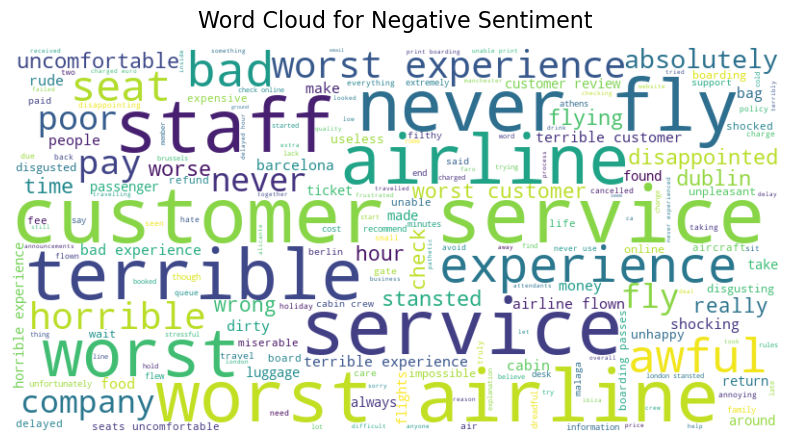

In [28]:
# Filter rows with negative sentiment
negative_df = negative_reviews_df[['Negative Sentences']]

# Extract text from the negative sentiment rows
negative_text = ' '.join(negative_df['Negative Sentences'])

# Lemmatize the text
negative_text = lemmatizer.lemmatize(negative_text)

# Tokenize and preprocess the text
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = set(['ryanair', 'flight', 'airport', 'us', 'one', 'airline' 'would','get','told', 'could', 'even', 'got', 'also', 'another', 'ever', 'like', 'way', 'go', 'asked', 'every', '2', 'plane'])
stop_words = stop_words.union(custom_stopwords)

tokens = word_tokenize(negative_text)
filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud for Negative Sentiment')
plt.text(0.5, 1.05, 'Word Cloud for Negative Sentiment',
         horizontalalignment='center', fontsize=16, transform=plt.gca().transAxes)
plt.show()

### Bigram Analysis

In [29]:
# Filter rows with negative sentiment
negative_df = ryan_pas_review_df[ryan_pas_review_df['Sentiment'] == 'Negative'][['Date Published', 'Comment', 'Comment title']]
negative_df['Overall_Comment'] = negative_df['Comment title'] + ' ' + negative_df['Comment']
negative_df.head()

,Date Published,Comment,Comment title,Overall_Comment
6,2024-01-03,The flight itself is operated by Malta air and...,"""they are really not better value""","""they are really not better value"" The flight ..."
8,2023-12-25,Ryanair ground service staff is really bad. If...,"""ground service staff is really bad""","""ground service staff is really bad"" Ryanair g..."
9,2023-12-08,I wanted to check in online a night before our...,"""they made us pay a No show fee""","""they made us pay a No show fee"" I wanted to c..."
11,2023-12-04,This airline charges you for almost every thin...,"""pay if you don’t check in online""","""pay if you don’t check in online"" This airlin..."
12,2023-12-04,At least 5 passengers denied boarding in Lisbo...,“At least 5 passengers denied boarding”,“At least 5 passengers denied boarding” At lea...


In [30]:
import pandas as pd
from nltk import bigrams, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import re

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuations = set(punctuation)

# Function to preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\d+', '', ''.join([c for c in text if c not in punctuations]))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Tokenize, preprocess and perform bigram analysis
all_tokens = [preprocess_text(review) for review in negative_df['Overall_Comment']]
tokens_flat = [token for sublist in all_tokens for token in sublist]
bi_grams = list(bigrams(tokens_flat))
bi_grams_count = Counter(bi_grams)

In [31]:
bi_grams_count

Counter({('really', 'better'): 2,
         ('better', 'value'): 2,
         ('value', 'flight'): 1,
         ('flight', 'operated'): 1,
         ('operated', 'malta'): 1,
         ('malta', 'air'): 2,
         ('air', 'ive'): 1,
         ('ive', 'always'): 1,
         ('always', 'found'): 2,
         ('found', 'cabin'): 1,
         ('cabin', 'crew'): 76,
         ('crew', 'pleasant'): 1,
         ('pleasant', 'respectful'): 1,
         ('respectful', 'however'): 1,
         ('however', 'said'): 1,
         ('said', 'handling'): 1,
         ('handling', 'agents'): 1,
         ('agents', 'either'): 1,
         ('either', 'pisa'): 1,
         ('pisa', 'stansted'): 2,
         ('stansted', 'stansted'): 1,
         ('stansted', 'bunch'): 1,
         ('bunch', 'found'): 1,
         ('found', 'rude'): 2,
         ('rude', 'argumentative'): 1,
         ('argumentative', 'hostile'): 1,
         ('hostile', 'like'): 1,
         ('like', 'hate'): 2,
         ('hate', 'work'): 1,
         ('work',

# Topic Modelling (Ashish)

In [32]:
import pandas as pd
import spacy
import re
import unicodedata
import contractions
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns  # Added for visualization
import gensim
import pyLDAvis
import pyLDAvis.gensim_models

In [37]:
# Load English language model for spaCy
nlp = spacy.load('en_core_web_sm')

# Define the list of stopwords
STOP_WORDS = set(stopwords.words('english'))

In [38]:
# Define the function to expand contractions
def expand(x):
    """Expand contractions in a sentence."""
    return contractions.fix(x)

# Define the function to remove accented characters
def remove_accented_chars(x):
    """Remove accented characters from a sentence."""
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

# Define the function to lemmatize words
def make_to_base(x):
    """Lemmatize words in a sentence."""
    x_list = []
    doc = nlp(x)
    for token in doc:
        lemma = str(token.lemma_)
        # Retain original text for pronouns and 'be'
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    return " ".join(x_list)

# Define the preprocessing function
def preprocess(df, d):
    """Preprocess a given document."""
    df[d] = df[d].apply(lambda x: x.lower())
    df[d] = df[d].apply(expand)
    df[d] = df[d].apply(lambda x: re.sub('[^A-Za-z0-9\s-]+', '', x))
    df[d] = df[d].apply(lambda x: " ".join(x.split()))
    df[d] = df[d].apply(remove_accented_chars)
    # df[d] = df[d].apply(lambda x: lemmatizer.lemmatize(x))
    df[d] = df[d].apply(make_to_base)
    
    df[d] = df[d].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

<>:30: DeprecationWarning: invalid escape sequence '\s'
<>:30: DeprecationWarning: invalid escape sequence '\s'
C:\Users\jagan\AppData\Local\Temp\ipykernel_3044\4291865545.py:30: DeprecationWarning: invalid escape sequence '\s'
  df[d] = df[d].apply(lambda x: re.sub('[^A-Za-z0-9\s-]+', '', x))


Best Parameters: {'n_components': 4}


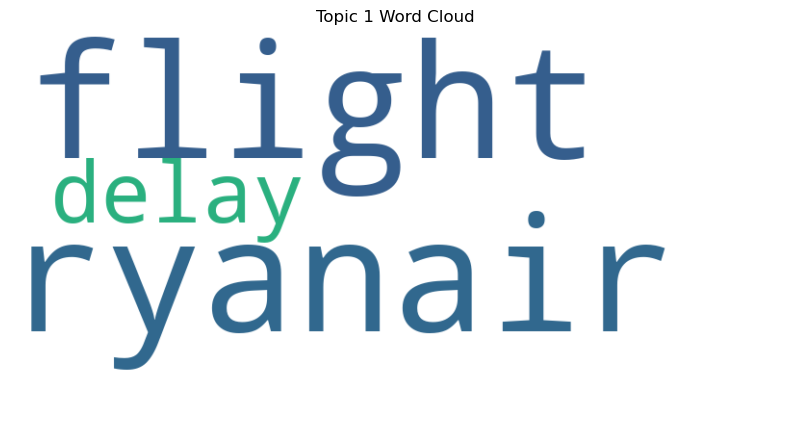

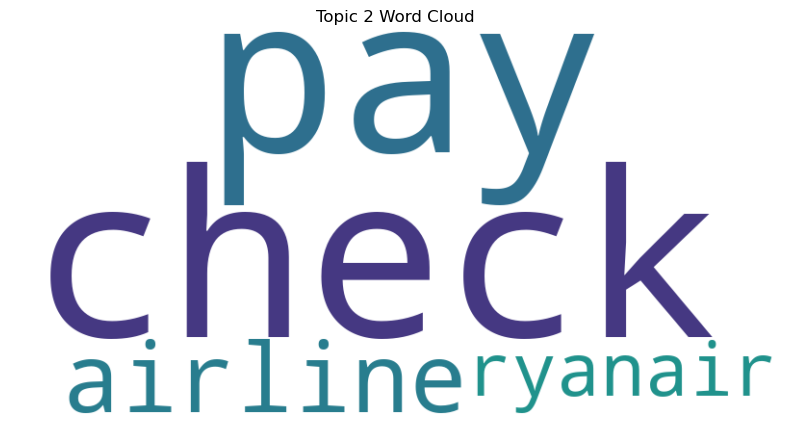

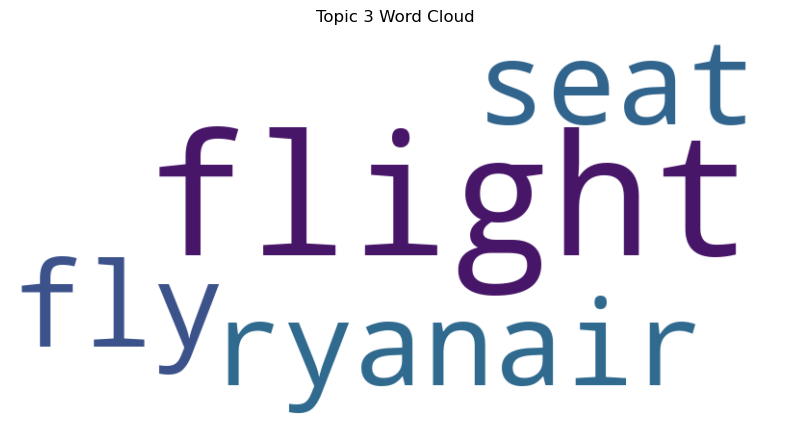

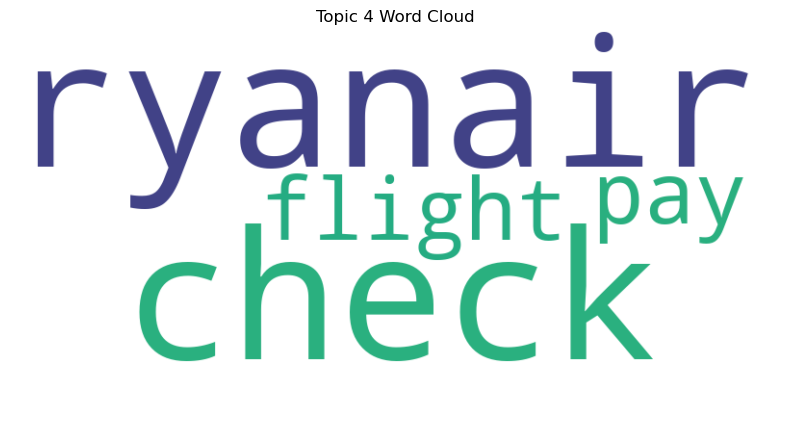

Topic 1: flight ryanair delay get hour
Topic 2: check pay airline ryanair flight
Topic 3: flight ryanair seat fly plane
Topic 4: check ryanair flight pay customer
Document 1 topic: flight ryanair seat fly plane
Document 2 topic: check pay airline ryanair flight
Document 3 topic: check ryanair flight pay customer
Document 4 topic: check pay airline ryanair flight
Document 5 topic: flight ryanair seat fly plane
Document 6 topic: check ryanair flight pay customer
Document 7 topic: flight ryanair seat fly plane
Document 8 topic: check ryanair flight pay customer
Document 9 topic: check pay airline ryanair flight
Document 10 topic: flight ryanair seat fly plane
Document 11 topic: flight ryanair seat fly plane
Document 12 topic: check ryanair flight pay customer
Document 13 topic: flight ryanair seat fly plane
Document 14 topic: check ryanair flight pay customer
Document 15 topic: flight ryanair seat fly plane
Document 16 topic: flight ryanair seat fly plane
Document 17 topic: check pay airl

In [40]:
# Load the dataset
df = pd.read_csv('./data/ryanair_reviews.csv')

# Preprocess the comments
preprocess(negative_df, 'Overall_Comment')

# Create CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(negative_df['Overall_Comment'])

# Define the parameter grid
param_grid = {'n_components': [4, 5, 6, 8]}

# Instantiate LDA model
lda = LatentDirichletAllocation(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(lda, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X)

# Fit LDA model with best parameters
best_lda_model = grid_search.best_estimator_
best_lda_model.fit(X)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Print the topics
feature_names = vectorizer.get_feature_names_out()
topic_words = {}
for topic_idx, topic in enumerate(best_lda_model.components_):
    top_words_idx = topic.argsort()[:-5:-1]
    topic_words[topic_idx] = [feature_names[i] for i in top_words_idx]

    # Generate word cloud for each topic
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(topic_words[topic_idx]))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx + 1} Word Cloud")
    plt.axis('off')
    plt.show()

# Assign topics to documents
doc_topics = best_lda_model.transform(X)
document_labels = np.argmax(doc_topics, axis=1)

# Define topic names dynamically based on top words
topic_names = {}
for topic_idx, topic in enumerate(best_lda_model.components_):
    top_words_idx = topic.argsort()[:-6:-1]  # Select top 5 words
    topic_words = [feature_names[i] for i in top_words_idx]
    topic_names[topic_idx] = " ".join(topic_words)

# Print topic names
for topic_idx, topic_name in topic_names.items():
    print(f"Topic {topic_idx + 1}: {topic_name}")

# Label documents with topics
document_labels = [topic_names[label] for label in document_labels]

# Convert sklearn LDA model to gensim format
vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
gensim_dictionary = gensim.corpora.Dictionary.from_corpus(gensim.matutils.Sparse2Corpus(X, documents_columns=False), id2word=vocab)
gensim_lda_model = gensim.models.ldamodel.LdaModel(id2word=gensim_dictionary, num_topics=len(topic_names), alpha='auto', eta='auto')
vis = pyLDAvis.gensim_models.prepare(gensim_lda_model, gensim.matutils.Sparse2Corpus(X, documents_columns=False), gensim_lda_model.id2word)
vis

# Print document labels
for i, label in enumerate(document_labels):
    print(f"Document {i + 1} topic: {label}")